In [1]:
using Gadfly, Roots, LsqFit, QuadGK

In [2]:
function reduced_van_der_waals(v, T)
    # Obtenido de http://rmf.smf.mx/pdf/rmf-e/52/1/52_1_65.pdf
    return 8.*T/(3.*v-1.)-3./(v^2)
end

reduced_van_der_waals (generic function with 1 method)

In [3]:
vector_isotermas = map(T -> (v-> reduced_van_der_waals(v, T)), collect(0.8:0.02:1.0));

La escala es MUY importante a la hora de graficar 

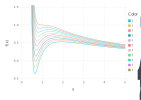

In [4]:
plot(vector_isotermas, 0.45, 5.0, Coord.cartesian(ymin = -0.5, ymax = 1.5))

In [5]:
vector_derivadas = map(D, vector_isotermas);

In [6]:
# Equivalente a todo lo que escribí arriba
minimos = map(fzero, vector_derivadas, 0.5*ones(length(vector_derivadas)));
maximos = map(fzero, vector_derivadas, 1.3*ones(length(vector_derivadas)));

In [7]:
# Tal vez la función map podría servir
pmin = Vector{Float64}()
pmax = Vector{Float64}()
for i in 1:length(vector_derivadas)
    push!(pmin, vector_isotermas[i](minimos[i]))
    push!(pmax, vector_isotermas[i](maximos[i]))
end
println(pmin)
println(pmax)

[-0.368193,-0.195352,-0.0301333,0.127495,0.277515,0.419843,0.554305,0.680582,0.798108,0.905756,1.0]

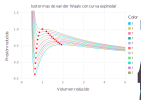

In [8]:
plot(
    layer(x = minimos,  y = pmin, Geom.point, Theme(default_color=colorant"red")), 
    layer(x = maximos,  y = pmax, Geom.point, Theme(default_color=colorant"red")), 
    layer(vector_isotermas, 0.45, 5.0), Coord.cartesian(ymin = -0.5, ymax = 1.5), 
    Guide.title("Isotermas de van der Waals con curva espinodal"),
    Guide.xlabel("Volumen reducido"),
    Guide.ylabel("Presión reducida"))

Cálculo de la curva espinodal

In [9]:
# Método 1 con reales
#
model(x::Float64, p::Vector) = (p[1] + x*p[2] + (x^2)*p[3] + (x^3)*p[4])/(p[5] + x*p[6] + (x^2)*p[7] + (x^3)*p[8])

model (generic function with 1 method)

In [10]:
# Método 2 con x::Vector reusando el método 1
function model(xv::Vector, p::Vector)
    return map(x->model(x::Float64, p::Vector), xv)
end

model (generic function with 2 methods)

In [11]:
model2(x::Float64, p::Vector) = (p[1] + x*p[2])/((x^3)*p[3])
function model2(xv::Vector, p::Vector)
    return map(x->model2(x::Float64, p::Vector), xv)
end
fit2 = curve_fit(model2, vcat(minimos, maximos), vcat(pmin,pmax), 1/0.9*ones(3))
beta2 = fit2.param;

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in Optim.MultivariateOptimizationResults{T,N,M}(::String, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Bool, ::Bool, ::Float64, ::Bool, ::Float64, ::Bool, ::Float64, ::Array{Optim.OptimizationState{LsqFit.LevenbergMarquardt},1}, ::Int64, ::Int64, ::Int64) at ./deprecated.jl:50
 in #levenberg_marquardt#1(::Float64, ::Float64, ::Int64, ::Float64, ::Bool, ::Array{Float64,1}, ::Array{Float64,1}, ::Function, ::LsqFit.#f#4{#model2,Array{Float64,1},Array{Float64,1}}, ::Calculus.#g#5{LsqFit.#f#4{#model2,Array{Float64,1},Array{Float64,1}},Symbol}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/levenberg_marquardt.jl:169
 in #lmfit#2(::Array{Any,1}, ::Function, ::LsqFit.#f#4{#model2,Array{Float64,1},Array{Float64,1}}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/curve_fit.jl:30
 in #curve_fit#3(::Array{Any,1}, ::Function, ::#model2, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}) at /hom

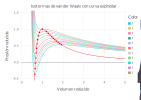

In [12]:
plot(
    layer(x = minimos,  y = pmin, Geom.point, Theme(default_color=colorant"red")), 
    layer(x = maximos,  y = pmax, Geom.point, Theme(default_color=colorant"red")), 
    layer(vector_isotermas, 0.45, 5.0), 
    layer(x -> model2(x, beta2), 0.45, 5.0, Theme(default_color=colorant"red"), ),
    layer(x -> 0, 0.0, 5.0, Theme(default_color=colorant"grey")),
    Coord.cartesian(ymin = -0.5, ymax = 1.5),
    Guide.title("Isotermas de van der Waals con curva espinodal"),
    Guide.xlabel("Volumen reducido"),
    Guide.ylabel("Presión reducida"))

In [13]:
sigma = estimate_errors(fit2)

3-element Array{Float64,1}:
 0.00158605 
 0.00237907 
 0.000793024

Cálculo de la curva de coexistencia por integración  (Ley de áreas de Maxwell)

In [14]:
vcoex = Vector()
pcoex = Vector()
for k in 1:length(vector_isotermas)-1
    vc = 0.5*(minimos[k] + maximos[k])
    pc = vector_isotermas[k](vc)
    area1 = -1.0
    area2 = -1.0
    dp = 0.01
    ii = 1
    v_ceros1 = 0.0
    v_ceros2 = 0.0
    while area1*area2 > 0
        area1 = area2
        v_ceros1 = fzero(x -> (vector_isotermas[k](x) - pc + dp*ii), 0.45, minimos[k]-0.01)
        v_ceros2 = fzero(x -> (vector_isotermas[k](x) - pc + dp*ii), maximos[k], maximos[k] + 20)
        area2 = quadgk(x -> (vector_isotermas[k](x) - pc + dp*ii), v_ceros1, v_ceros2)[1]
        ii = ii + 1
    end
    push!(vcoex, v_ceros1)
    push!(vcoex, v_ceros2)
    push!(pcoex, vector_isotermas[k](v_ceros1))
    push!(pcoex, vector_isotermas[k](v_ceros2))
end
push!(vcoex, 1.0)
push!(pcoex, 1.0)
#vcoex, pcoex

21-element Array{Any,1}:
 0.381607
 0.381607
 0.422724
 0.422724
 0.476989
 0.476989
 0.524593
 0.524593
 0.585742
 0.585742
 0.64065 
 0.64065 
 0.709544
 0.709544
 0.772664
 0.772664
 0.840265
 0.840265
 0.912616
 0.912616
 1.0     

In [15]:
map(length, [vcoex, pcoex])

2-element Array{Int64,1}:
 21
 21

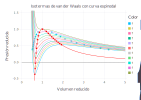

In [16]:
plot(
    layer(x = minimos,  y = pmin, Geom.point, Theme(default_color=colorant"red")), 
    layer(x = maximos,  y = pmax, Geom.point, Theme(default_color=colorant"red")), 
    layer(vector_isotermas, 0.334, 5.0), 
    layer(x -> model2(x, beta2), 0.45, 5.0, Theme(default_color=colorant"red"), ),
    layer(x -> 0, 0.0, 5.0, Theme(default_color=colorant"grey")),
    layer(x = vcoex, y = pcoex, Geom.point),
    Coord.cartesian(ymin = -0.5, ymax = 1.5),
    Guide.title("Isotermas de van der Waals con curva espinodal"),
    Guide.xlabel("Volumen reducido"),
    Guide.ylabel("Presión reducida"))

In [17]:
# Creo que es necesario usar cosas con Float64 para que funcione
fit3 = curve_fit(model, vcoex, pcoex, 1/0.9*ones(8));

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in Optim.MultivariateOptimizationResults{T,N,M}(::String, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Bool, ::Bool, ::Float64, ::Bool, ::Float64, ::Bool, ::Float64, ::Array{Optim.OptimizationState{LsqFit.LevenbergMarquardt},1}, ::Int64, ::Int64, ::Int64) at ./deprecated.jl:50
 in #levenberg_marquardt#1(::Float64, ::Float64, ::Int64, ::Float64, ::Bool, ::Array{Float64,1}, ::Array{Float64,1}, ::Function, ::LsqFit.#f#4{#model,Array{Any,1},Array{Any,1}}, ::Calculus.#g#5{LsqFit.#f#4{#model,Array{Any,1},Array{Any,1}},Symbol}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/levenberg_marquardt.jl:169
 in #lmfit#2(::Array{Any,1}, ::Function, ::LsqFit.#f#4{#model,Array{Any,1},Array{Any,1}}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/curve_fit.jl:30
 in #curve_fit#3(::Array{Any,1}, ::Function, ::#model, ::Array{Any,1}, ::Array{Any,1}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/curv

In [18]:
beta3 = fit3.param;

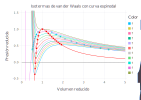

In [19]:
plot(
    layer(x = minimos,  y = pmin, Geom.point, Theme(default_color=colorant"red")), 
    layer(x = maximos,  y = pmax, Geom.point, Theme(default_color=colorant"red")), 
    layer(vector_isotermas, 0.45, 5.0), 
    layer(x -> model2(x, beta2), 0.45, 5.0, Theme(default_color=colorant"red"), ),
    layer(x -> 0, 0.0, 5.0, Theme(default_color=colorant"grey")),
    layer(x = vcoex, y = pcoex, Geom.point),
    layer(x -> model(x, beta3), 0.0, 5.0, Theme(default_color=colorant"violet")),
    Coord.cartesian(ymin = -0.5, ymax = 1.5),
    Guide.title("Isotermas de van der Waals con curva espinodal"),
    Guide.xlabel("Volumen reducido"),
    Guide.ylabel("Presión reducida"))

In [20]:
model4(x::Float64, p::Vector) = 1. + ((1.-x)*p[1] + (1.-x)^2*p[2] + (1.-x)^3*p[3])/(1. + (1.-x)*p[4] + (1.-x)^2*p[5] + (1.-x)^3*p[6])
function model4(xv::Vector, p::Vector)
    return map(x->model4(x::Float64, p::Vector), xv)
end
fit4 = curve_fit(model4, vcoex, pcoex, 1/0.9*ones(6))
beta4 = fit4.param;

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in Optim.MultivariateOptimizationResults{T,N,M}(::String, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Bool, ::Bool, ::Float64, ::Bool, ::Float64, ::Bool, ::Float64, ::Array{Optim.OptimizationState{LsqFit.LevenbergMarquardt},1}, ::Int64, ::Int64, ::Int64) at ./deprecated.jl:50
 in #levenberg_marquardt#1(::Float64, ::Float64, ::Int64, ::Float64, ::Bool, ::Array{Float64,1}, ::Array{Float64,1}, ::Function, ::LsqFit.#f#4{#model4,Array{Any,1},Array{Any,1}}, ::Calculus.#g#5{LsqFit.#f#4{#model4,Array{Any,1},Array{Any,1}},Symbol}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/levenberg_marquardt.jl:169
 in #lmfit#2(::Array{Any,1}, ::Function, ::LsqFit.#f#4{#model4,Array{Any,1},Array{Any,1}}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/curve_fit.jl:30
 in #curve_fit#3(::Array{Any,1}, ::Function, ::#model4, ::Array{Any,1}, ::Array{Any,1}, ::Array{Float64,1}) at /home/rafael/.julia/v0.5/LsqFit/src/